In [2]:
import json 
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.image as mpimg 
from sklearn.model_selection import train_test_split
from keras import Model, Sequential
from keras.layers import (Dense, Flatten,Input,BatchNormalization,Dropout)
import random
from collections import Counter
import matplotlib.pyplot as plt

### Data preprocessing

In [3]:
# Get the image files not json and XML from the dataset
img_list = [i for i in os.listdir("垃圾分类数据集") if i not in ["JSON","XML"]] 
#Get the labels from the json files
json_list = os.listdir("垃圾分类数据集/JSON/outputs")
#We sort the data according to its names
json_list.sort(key=lambda x:int(x.split("_")[1].replace(".json","")),reverse=False)
img_list.sort(key=lambda x:int(x.split("_")[1].replace(".jpg","")),reverse=False)


In [4]:
#Check whether the names in json is the same with the name of the images. If it is the same print 0 ,if it is not the same print 1.
t = 0
for i in range(len(json_list)):
    if json_list[i].split("_")[1].replace(".json","") != img_list[i].split("_")[1].replace(".jpg",""):
        t+=1
print(t)

0


In [5]:
#We labeled the images according to json files.
Y = []
#not_label list is used to store the data which has no labels
not_label = []
for j in json_list:
    ### 
    try:
        f = open('垃圾分类数据集/JSON/outputs/'+j,encoding='UTF-8')
        #Convert json into list
        t = json.load(f)
        Y.append(t["outputs"]["object"][0]["name"].split("/")[1])
    except:
        # Put all the json files that do not contains labels into the not_label list
        not_label.append(j)


In [6]:
# Check which images has no labels
print(not_label)

['fimg_721.json', 'fimg_890.json', 'fimg_918.json', 'fimg_1464.json', 'fimg_1678.json', 'fimg_3376.json']


In [7]:
# We put the location of the images into the list
not_numby = [721,890,918,1464,1678,3376]

In [8]:
# Delete all the images with no labels
img_list = [i for i in img_list if int(i.split("_")[1].replace(".jpg","")) not in not_numby]
json_list = [i for i in json_list if int(i.split("_")[1].replace(".json","")) not in not_numby]

In [9]:
# Check how many labels(categories) among all the data
print("The number of categories：%s"%len(set(Y)))

The number of categories：40


In [10]:
class_numby = len(set(Y))

In [11]:
#Read every image and resize every image as 224*224
X_data = []
for file in img_list:
    lena = mpimg.imread('垃圾分类数据集/' + file)
    X_data.append(cv2.resize(lena,(224,224)))
hei_bai =[] 
for i in range(len(X_data)):
    if X_data[i].shape[2] !=3:
        print(i)
        hei_bai.append(i)

In [12]:
# All the image that have different shape
hei_bai  = [1414,1924,2209,2216,2389,2487,2586,3243,3312,3654,4097]

In [13]:
# Get all the data which is 224*224*3
y_data = []
img_list2 = []
for z in [i for i in range(len(img_list)) if i not in hei_bai]:
    y_data.append(Y[z])
    img_list2.append(img_list[z])

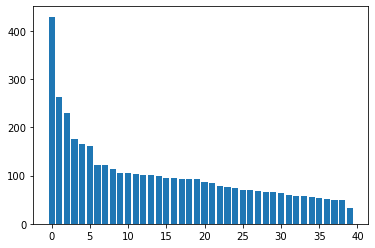

In [14]:
# Plot the data and labels to have a better overview
names = []
numby = []
for name,num in Counter(y_data).most_common():
    names.append(name)
    numby.append(num)
plt.bar(range(len(numby)),numby)
plt.show()

In [15]:
# We can see the fourty categories names
print(names)  

['塑料玩具', '一次性快餐盒', '毛绒玩具', '塑料衣架', '插头电线', '烟蒂', '竹筷', '锅', '洗发水瓶', '易拉罐', '枕头', '蛋壳', '污损塑料', '皮鞋', '塑料碗盆', '化妆品瓶', '酒瓶', '包', '水果果肉', '食用油桶', '茶叶渣', '玻璃杯', '充电宝', '旧衣服', '水果果皮', '牙签', '菜叶菜根', '剩饭剩菜', '纸板箱', '破碎花盆及碟碗', '砧板', '大骨头', '快递纸袋', '干电池', '鱼骨', '软膏', '金属食品罐', '调料瓶', '过期药物', '饮料瓶']


In [16]:
# Put all the labels as the dummies data
y_data = pd.get_dummies(y_data)

In [17]:
# Split the dataset
x_train,x_test,y_train,y_test=train_test_split(img_list2,y_data,test_size=0.2)

In [20]:
print(len(x_train))
print(len(y_train))
#print(len(y_train))


3318
3318


In [21]:
def get_data(x_train,y_train,batch_size):
    while True:
        numby = len(x_train)
        index = random.sample(range(numby),batch_size)
        X_ = []
        Y_ = []
        for i in index:
            lena = mpimg.imread('垃圾分类数据集/' + x_train[i])
            X_.append(cv2.resize(lena,(224,224)))
            
            Y_.append(y_train.iloc[i].tolist())
            
        yield np.array(X_)/255,np.array(Y_)

In [22]:
# Check one x and y
x,y = next(get_data(x_train,y_train,16))

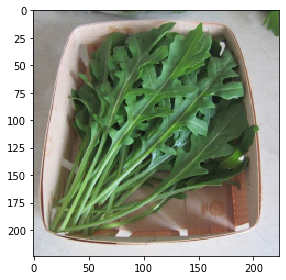

In [36]:
# Check the dimensions of x
import skimage.io as io
x.shape
io.imshow(x[2])

In [37]:
# Check the y dimensions
y.shape
print(np.array(y[2]).T)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0]


Neural Network

In [22]:
# The structure of the BP Neral network
def BP(num_classes):
    image_input = Input(shape = (224,224,3))
    x = Flatten(name = 'flatten')(image_input)
    x = BatchNormalization()(x)
    x = Dense(512,activation = 'sigmoid',name = 'fullc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(512,activation = 'sigmoid',name = 'fullc2')(x)
    x = Dropout(0.3)(x)
    # output layer
    x = Dense(num_classes,activation = 'softmax',name = 'fullc3')(x)

    model = Model(image_input,x,name = 'BP')
    return model
model = BP(class_numby)
model.summary()

Model: "BP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150528)            602112    
_________________________________________________________________
fullc1 (Dense)               (None, 512)               77070848  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
fullc2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0        

In [23]:
# Loss function and optimizer
model.compile(loss = 'categorical_crossentropy',
        optimizer = "adam",
        metrics = ['accuracy'])

In [24]:
epochs = 50
Batch_size = 128

In [25]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
history = model.fit_generator(get_data(x_train,y_train,batch_size=Batch_size),
                   steps_per_epoch=100,
                   validation_data=get_data(x_test,y_test,batch_size=Batch_size),
                   validation_steps=10,
                   epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
100/100 [==============================] - 95s 953ms/step - loss: 3.4047 - accuracy: 0.1236 - val_loss: 3.4839 - val_accuracy: 0.1422
Epoch 2/50
100/100 [==============================] - 91s 913ms/step - loss: 3.2307 - accuracy: 0.1532 - val_loss: 3.2634 - val_accuracy: 0.1586
Epoch 3/50
100/100 [==============================] - 86s 859ms/step - loss: 3.1578 - accuracy: 0.1628 - val_loss: 3.2161 - val_accuracy: 0.1844
Epoch 4/50
100/100 [==============================] - 85s 853ms/step - loss: 3.0964 - accuracy: 0.1784 - val_loss: 3.1611 - val_accuracy: 0.1859
Epoch 5/50
100/100 [==============================] - 86s 860ms/step - loss: 3.0646 - accuracy: 0.1795 - val_loss: 3.1358 - val_accuracy: 0.1852
Epoch 6/50
100/100 [==============================] - 88s 875ms/step - loss: 3.0130 - accuracy: 0.1940 - val_loss: 3.1461 - val_accuracy: 0.1789
Epoch 7/50
100/100 [==============================] - 

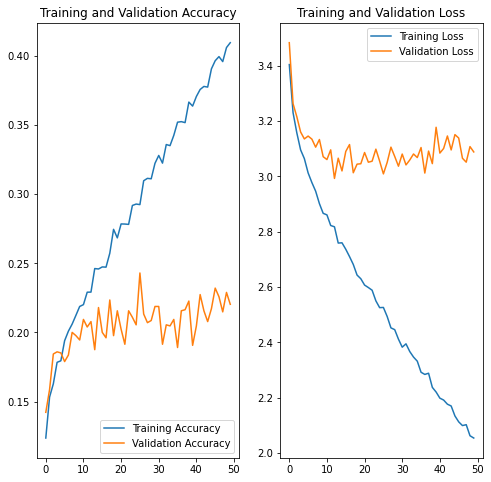

In [26]:
#Plot the accuracy for our model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#Plot the loss for our model
loss = history.history['loss']
val_loss = history.history['val_loss']
#The x-axis is the range of epochos
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Plot it as two subplots and with legend
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# The accuracy are about 10 percent
model.predict(x)  # Check whether every prediction is the same

array([[6.03419766e-02, 4.62764967e-03, 1.95481512e-03, 7.13237852e-04,
        6.46751281e-03, 9.41633433e-03, 3.30160209e-03, 8.39422736e-03,
        1.65195466e-04, 2.23613065e-03, 2.17468338e-03, 2.35388149e-02,
        1.71463639e-02, 1.00365253e-02, 7.02082738e-03, 2.91862502e-03,
        2.13609487e-02, 4.04251157e-04, 4.16937750e-03, 8.94788206e-02,
        2.18734108e-02, 1.25863869e-02, 1.72574650e-02, 7.06044957e-03,
        3.28828208e-03, 6.72127679e-03, 4.30736411e-03, 1.57201868e-02,
        2.85315560e-04, 4.13256558e-03, 6.01301994e-03, 9.92348418e-04,
        3.43674868e-02, 8.29751976e-03, 5.41704940e-03, 7.67087098e-03,
        5.28604314e-02, 4.78834569e-01, 3.36064249e-02, 2.83963722e-03],
       [1.89529564e-02, 3.23758880e-03, 4.55732681e-02, 1.04500074e-02,
        1.86831690e-03, 1.72100309e-02, 4.33760183e-03, 5.84579213e-03,
        5.80115244e-02, 3.87582695e-03, 4.11468936e-05, 6.34208322e-03,
        1.59363879e-03, 1.43905869e-02, 4.38229763e-04, 2.86561

In [28]:
#Predict all the image from the test set
perdict_list = ["1.png","2.png","3.png","4.png","5.png",
               "6.png","7.png","8.png","9.png","10.png"]

In [29]:
# Predict every images
for img_file in perdict_list:
    img = cv2.imread("test/"+img_file)
    # cut the imges
    # Get the height and width
    height = img.shape[0]
    weight = img.shape[1]
    tmp_img = img[int((1/4)*height):int((3/4)*height),]
    img1 = tmp_img[:,0:int((1/3)*weight)]
    img2 = tmp_img[:,int((1/3)*weight):int((2/3)*weight)]
    img3 = tmp_img[:,int((2/3)*weight):]

    # After cutting we convert the size of the picture as the input in the network
    img1 = cv2.resize(img1,(224,224))
    img2 = cv2.resize(img2,(224,224))
    img3 = cv2.resize(img3,(224,224))
    X_test = np.array([img1,img2,img3])/255
    # model prediction for every test of three images
    y_pre= model.predict(X_test)
    index = np.argmax(y_pre,1)
    print("Picture%s's three categories are:%s,%s,%s"%(img_file,y_data.columns.values[index[0]],y_data.columns.values[index[1]],y_data.columns.values[index[2]]))

Picture1.png's three categories are':塑料玩具,污损塑料,污损塑料
Picture2.png's three categories are':化妆品瓶,塑料衣架,枕头
Picture3.png's three categories are':塑料玩具,充电宝,枕头
Picture4.png's three categories are':包,洗发水瓶,塑料玩具
Picture5.png's three categories are':快递纸袋,包,插头电线
Picture6.png's three categories are':食用油桶,易拉罐,插头电线
Picture7.png's three categories are':锅,洗发水瓶,污损塑料
Picture8.png's three categories are':一次性快餐盒,食用油桶,塑料衣架
Picture9.png's three categories are':一次性快餐盒,塑料碗盆,一次性快餐盒
Picture10.png's three categories are':快递纸袋,一次性快餐盒,食用油桶
